# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [1]:
from pryngles import *

## External modules

In [2]:
import pandas as pd
from collections import OrderedDict as odict
from copy import deepcopy
import random

#Aliases
print_df=Misc.print_df
sci=Science

#Default colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)
SPANGLE_COLORS=dict()
SPANGLE_COLORS[SOLID_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[GRANULAR_SPANGLE]=[180,0.8,0.0]
SPANGLE_COLORS[GAS_SPANGLE]=[27,0.5,1.0]
SPANGLE_COLORS[STAR_SPANGLE]=[59,0.7,1.0]
SHADOW_COLOR=[180,0.2,0.0]

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [3]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:
        
            Mandatory:

                nspangles: int, default = 0:
                    Number of spangles in spangling.

            Optional:

                body_hash: string, default = None:
                    Hash identifying the body to which spangles are associated 
                    (see Body documentation for explanation about hash).

                spangle_type: int, default = 0:
                    Type of spangle (see *_SPANGLE in Consts module).

                n_equ: numpy Array (3), default = [0,0,1]:
                    unitary vector normal to {equ} (equatorial) plane.

                alpha_equ: float, default = 0:
                    Roll angle of x-axis of equatorial system (not implemented yet)

                n_obs: list/array (3), default = []:
                    Vector towards the observer.

                alpha_obs: float, default = 0:
                    Roll angle of x-axis of observer system (not implemented yet)

                n_luz: list/array (3), default = []:
                    Vector towards the light-source.  Magnitude of this vector is taken as
                    the distance to the light-source.

                center_equ: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {equ} (equatorial) system.

                center_ecl: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {ecl} (ecliptic) system.
                    
                w, t0: float [rad, rad/ut, ut], default = 0, 0, 0:
                    Angular velocity and reference time.

        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.
                
            n_obs: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {obs} observer direction.
            
            alpha_obs: float, default = 0:
                Roll angle of x-axis of observer system (not implemented yet)

Secondart attributes:

    dim: int:
        Dimension of the Spangler.

    d_luz: float:
        Distance to light-source.

    d_obs: float:
        Distance to observer.

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.

Secondary attributes:

    M_ecl2obs, M_obs2ecl: array (3x3):
        Transformation matrices going from {obs} <-> {ecl}.

    M_ecl2equ, M_equ2ecl: array (3x3):
        Transformation matrices going from {equ} <-> {ecl}.
        
    M_ecl2luz, M_luz2ecl: array (3x3):
        Transformation matrices going from {luz} <-> {ecl}.
        
Public methods:
    
    update_positions: update positions by changing observer orientation.
"""

In [138]:
#Columns of spangling
SPANGLER_COLUMNS=odict({
    "body_hash":"",

    #Type of spangle
    "type":SOLID_SPANGLE, #For a list of spangle types see the constants module.
    "dim":2, #Dimension of the spangle, 3: sphere, 2: circle, ring

    #Lengh-scale
    "scale":1, #The length scale of the body, eg. for a ring this is the outer radius

    #Body parameters
    "n_equ":[0,0,1], #Direction of the equator of the body with respect
    "alpha_equ":0, #Zero meridian of equatorial system
    "w":0, #Rotational angular velocity
    "t0":0, #Initial time, q = q0 + w (t - t0)

    #Coordinates of the spangle (cartesian and spherical) in the body-centric system
    "center_equ":[0,0,0],#Center of the body with respect to barycenter
    "x_equ":1,"y_equ":0,"z_equ":1, #Cartesian coordinates
    "r_equ":1,"q_equ":0,"f_equ":0, #Spherical coordinates: q: longitude, f: latitude
    "ns_equ":[0,0,1], #Unitary vector normal to the spangle

    #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
    "center_ecl":[0,0,0], #Center of the body with respect to barycenter
    "x_ecl":1,"y_ecl":0,"z_ecl":0, #Cartesian coordinates of the spangle
    "ns_ecl":[0,0,1],#Unitary vector normal to the spangle, calculated in the class

    #Coordinates of the spangle (cartesian and spherical) in the observer system
    "center_obs":[0,0,0], #Center of the body with respect to observer
    "x_obs":1,"y_obs":0,"z_obs":0, #Cartesian coordinates of the spangle
    "rho_obs":1,"az_obs":0,"cos_tobs":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_obs":1, #Angle between normal to spangle and direction of observer
    "d_obs":1, #Distance of the Spangle to light-source
    
    #Coordinates of the spangle (cartesian and spherical) in the light-source system
    "center_luz":[0,0,0],#Center of the body with respect to light
    "x_luz":1,"y_luz":0,"z_luz":0,#Calculated in the class
    "rho_luz":1,"az_luz":0,"cos_tluz":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_luz":1, #Angle between normal to spangle and direction of light-source
    "d_luz":1, #Distance of the Spangle to light-source

    #Coordinates of the spangle (cartesian and spherical) in the intersection system
    "center_int":[0,0,0],#Center of the body 
    "x_int":1,"y_int":0,"z_int":0,#Cartesian coordinates
    "rho_int":1,"az_int":0,"cos_tint":0, #Pseudo cylindrical coordinates (rho, q, cos(theta))
    "cos_int":1, #Angle between normal to spangle and direction of intersection
    "d_int":1, #Distance of the Spangle to intersection

    #Geometrical parameters
    "asp":1.0, #Effective area of the spangle
    "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5

    #Optical parameters
    "albedo_gray_normal":1.0,
    "tau_gray_optical":0.0,
    
    #Special states
    "unset":True, #State has not been set
    "hidden":False, #The spangle is not taken into account for photometry
    "source":False, #The spangle belongs to a light-source (it does not reflect light)
})

SPANGLER_VISIBILITY_STATES=odict({
    #Spangle state
    "visible":False, #The spangle is visible from observer
    "shadow":False, #The spangle is in the shadow of other spangle
    "indirect":False, #The spangle is indirectly illuminated
    "emit":False, #The spangle is emmitting
    "intersect":False, #Intermediate state to calculate intersections
})
SPANGLER_COLUMNS.update(SPANGLER_VISIBILITY_STATES)

SPANGLER_SOURCE_STATES=odict({
    "illuminated":False, #The spangle is illuminated by the light-source
    "transmit":False, #The spangle is illuminated but transmitting light
    "transit":False, #The spangle is transiting
    "occult":False, #The spangle is occulted by a light source
})
SPANGLER_COLUMNS.update(SPANGLER_SOURCE_STATES)

SPANGLER_RING_BORDER=100

In [139]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 nspangles=1,
                 body_hash=None,
                 spangle_type=SOLID_SPANGLE,
                 n_equ=SPANGLER_COLUMNS["n_equ"],
                 alpha_equ=SPANGLER_COLUMNS["alpha_equ"],
                 n_obs=[0,0,1],
                 alpha_obs=0,
                 n_luz=[0,0,1],
                 center_equ=SPANGLER_COLUMNS["center_equ"],
                 center_ecl=SPANGLER_COLUMNS["center_ecl"],
                 w_equ=SPANGLER_COLUMNS["w"],
                 t0_equ=SPANGLER_COLUMNS["t0"],
                 #Initialization with a list of 
                 spanglers=[]):

        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            verbose(VERB_SIMPLE,f"Joining {len(spanglers)} spanglers")
            self._join_spanglers(spanglers,
                                 n_obs=n_obs,alpha_obs=alpha_obs,
                                 n_luz=n_luz)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            self.geometry="Vanilla"
            
            #Update default values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not body_hash:
                verbose(VERB_SIMPLE,f"Generating random hash")
                self.body_hash=str(random.getrandbits(16))
            else:
                self.body_hash=body_hash
                
            self._defaults.update(dict(body_hash=self.body_hash))
            
            if spangle_type:
                self._defaults.update(dict(type=spangle_type))

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,columns=self._defaults.keys())

                #Update positions
                self.set_positions(n_equ=n_equ,alpha_equ=alpha_equ,
                                   n_obs=n_obs,alpha_obs=alpha_obs,
                                   n_luz=n_luz,
                                   center_equ=center_equ,center_ecl=center_ecl)
        
            else:        
                verbose(VERB_SIMPLE,f"Creating a blank Spangler")
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
                
    # Prototype
    def _join_spanglers(self,spanglers,nobs=[0,0,1],alpha_obs=0,n_luz=[0,0,1]):pass
    
Spangler.__doc__=Spangler_doc

In [140]:
def update_state(self):
    """Update state of spangles
    """
    verbose(VERB_SIMPLE,f"Updating state: visibility and illumination")

    #Set state
    self.data.unset=False
    
    #By default all spangles are illuminated
    self.data.illuminated=True
    self.data.transmit=False
    self.data.visible=True

    
    #Conditions for no visibility
    """
    | Hidden
        (
            & Spangle type is not semitransparent
            & cos_obs < 0: spangler it is towards the observer
        )
    """
    cond=\
    (self.data.hidden)|\
    (\
     (~self.data.type.isin(SEMITRANSPARENT_SPANGLES))&\
     (self.data.cos_obs<0)
    )
    self.data.loc[cond,"visible"]=False
    
    #All semitransparent are illuminated
    cond=(~self.data.hidden)&(self.data.type.isin(SEMITRANSPARENT_SPANGLES))
    self.data.loc[cond,"illuminated"]=True

    #Conditions for no illumination:
    """
    | Hidden
    (
        & Spangle type is not semitransparent
        & cos_luz < 0: spangler it is towards the observer
    )
    """    
    cond=\
    (self.data.hidden)|\
    (\
     (~self.data.type.isin(SEMITRANSPARENT_SPANGLES))&\
     (self.data.cos_luz<0)
    )
    self.data.loc[cond,"illuminated"]=False
    
    #Conditions for transmission:
    """
    & No hidden
    (
        & Spangle type is semitransparent
        & cos_obs . cos_luz < 0: observer and light source are in opposite sides
    )
    """    
    #Semitransparent spangles transmit
    cond=\
    (~self.data.hidden)&\
    (\
     (self.data.type.isin(SEMITRANSPARENT_SPANGLES))&\
     ((self.data.cos_luz*self.data.cos_obs)<=0)
    )
    self.data.loc[cond,"transmit"]=True

Spangler.update_state=update_state

In [141]:
def set_observer(self,nvec=[],alpha=0):
    """
    Set the positions and orientation of spanglers in the observer system.

    Parametersa:

        nvec: list/array (3), default = []:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_obs.

        Rotation matrices M_ecl2obs, M_obs2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting observer")

    if len(nvec)>0:
        verbose(VERB_VERIFY,f"Generating observer matrices from nvec = {nvec}")
        
        #Unitary observer vector
        self.n_obs,self.d_obs=spy.unorm(nvec)
        self.alpha_obs=alpha
        self.rqf_obs=sci.spherical(self.n_obs)

        #Transformation matrices
        self.M_obs2ecl,self.M_ecl2obs=Science.rotation_matrix(self.n_obs,self.alpha_obs)
        
    #Update positions
    self.data[["x_obs","y_obs","z_obs"]]=\
        [np.matmul(self.M_ecl2obs,r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the observer reference system
    self.data.center_obs=\
        [np.matmul(self.M_ecl2obs,r) for r in np.array(self.data.center_ecl)]
    
    #Pseudo-cylindrical coordinates in the observer system
    self.data[["rho_obs","az_obs","cos_tobs"]]=\
        [sci.pcylindrical(r) for r in np.array(self.data[["x_obs","y_obs","z_obs"]])-np.vstack(self.data.center_obs)]

    #Compute distance to light-source of each spangle
    self.data["d_obs"]=self.d_obs-self.data["z_obs"] #Asuming d_luz > radius of the object

    #Direction of spangle with respect to observer
    cond=(self.data.dim==2)
    self.data.loc[cond,"cos_obs"]=[np.dot(n_ecl,self.n_obs) for n_ecl in self.data.ns_ecl[cond]]
    #For ring or circular Spanglers
    self.data.loc[~cond,"cos_obs"]=self.data.cos_tobs[~cond]
    
    #Update visibility
    self.update_state()
    
Spangler.set_observer=set_observer

In [142]:
def set_luz(self,nvec=[]):
    """
    Set the positions and orientation of spanglers in the light-source {luz} system.

    Parameters:

        nvec: list/array (3), default = []:
            Normal vector towards the light-source.
            
    Return:
        None

    Update:

        Coordinates of the spangles, (x_luz,y_luz,z_luz) and their spherical 
        counterparts (r_luz,t_luz,f_luz).

        Normal to spangles, ns_luz.

        Rotation matrices M_ecl2luz, M_luz2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting light-source")

    if len(nvec)>0:
        verbose(VERB_VERIFY,f"Generating light-source matrices from nvec = {nvec}")
        
        #Unitary luzerver vector
        self.n_luz,self.d_luz=spy.unorm(nvec)
        self.rqf_luz=sci.spherical(self.n_luz)

        #Transformation matrices
        self.M_luz2ecl,self.M_ecl2luz=Science.rotation_matrix(self.n_luz,0)
        
    #Update positions
    self.data[["x_luz","y_luz","z_luz"]]=\
        [np.matmul(self.M_ecl2luz,r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the light-source reference system
    self.data.center_luz=\
        [np.matmul(self.M_ecl2luz,r) for r in np.array(self.data.center_ecl)]
    
    #Pseudo-cylindrical coordinates in the observer system
    self.data[["rho_luz","az_luz","cos_tluz"]]=\
        [sci.pcylindrical(r) for r in np.array(self.data[["x_luz","y_luz","z_luz"]])-np.vstack(self.data.center_luz)]

    #Compute distance to light-source of each spangle
    self.data["d_luz"]=self.d_luz-self.data["z_luz"] #Asuming d_luz > radius of the object

    cond=(self.data.dim==2)
    self.data.loc[cond,"cos_luz"]=[np.dot(n_ecl,self.n_luz) for n_ecl in self.data.ns_ecl[cond]]
    #For ring or circular Spanglers
    self.data.loc[~cond,"cos_luz"]=self.data.cos_tluz[~cond]

    #Update illumination
    self.update_state()

Spangler.set_luz=set_luz

In [143]:
def set_rotation(self,body_hash,w,t0):
    """
    Set rotational parameters
    """
    cond=(self.data.body_hash==body_hash)
    self.data.loc[cond,"w"]=w
    self.data.loc[cond,"t0"]=t0
    
Spangler.set_rotation=set_rotation

In [144]:
def set_positions(self,
                  n_equ=[],alpha_equ=0,
                  n_obs=[],alpha_obs=0,
                  n_luz=[],
                  center_equ=[],center_ecl=[],
                  t=None
                 ):
    """
    Set the positions and orientation of spanglers in all reference systems.

    Parameters:

        n_equ: list/array (3), default = []:
            Normal vector towards north pole equatorial system.

        n_obs: list/array (3), default = []:
            Normal vector towards the observer.
            
        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

        n_luz: list/array (3), default = []:
            Normal vector towards the light-source.

        center_equ: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        center_ecl: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        t: float, default = None:
            Time.  This quantity is used to update the equatorial coordinates.

    Optional:

        alpha_equ: float, default = 0:
            Roll angle of x-axis of equatorial system (not implemented yet)

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (X_ecl,Y_ecl,Z_ecl) and their spherical 
        counterparts (R_ecl,T_ecl,F_ecl) with respect to the barycenter.

        Coordinates of the spangles, (x_ecl,y_ecl,z_ecl) and their spherical 
        counterparts (r_ecl,t_ecl,f_ecl) with respect to the body center.

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_equ, ns_ecl, ns_obs.

        Rotation matrices M_equ2ecl
    """
    verbose(VERB_SIMPLE,f"Setting positions")

    if len(n_equ)>0:
        verbose(VERB_VERIFY,f"Generating equatorial transformation matrices from n_equ = {n_equ}")
        
        #Unitary equatorial vector
        n_equ,one=spy.unorm(n_equ)
        self.data["n_equ"]=[n_equ]*self.nspangles

        #Transformation matrices
        self.M_equ2ecl,self.M_ecl2equ=sci.rotation_matrix(n_equ,alpha_equ)
        
    if len(n_obs)>0:
        self.n_obs,one=spy.unorm(n_obs)

    if len(n_luz)>0:
        self.n_luz,one=spy.unorm(n_luz)
     
    #Update equatorial coordinates by rotation
    if t is not None:
        verbose(VERB_VERIFY,f"Updating rotations at t = {t}")

        self.data["q_equ"]=[q+w*(t-t0) for q,w,t0 in zip(self.data.q_equ,self.data.w,self.data.t0)]
        self.data[["x_equ","y_equ","z_equ"]]=\
            [sci.cartesian(r) for r in np.array(self.data[["r_equ","q_equ","f_equ"]])]
        
        #Update normal vectors
        if self.sample.dim>2:
            self.data["ns_equ"]=[spy.unorm(list(r))[0] for r in np.array(self.data[["x_equ","y_equ","z_equ"]])]
                
    #Update center
    if len(center_equ)>0:
        verbose(VERB_VERIFY,f"Updating center in {{equ}} to {center_equ}")
        self.data["center_equ"]=[center_equ]*self.nspangles
    if len(center_ecl)>0:
        verbose(VERB_VERIFY,f"Updating center {{ecl}} to {center_ecl}")
        self.data["center_ecl"]=[center_ecl]*self.nspangles
        
    #Convert from equatorial to ecliptic
    self.data[["x_ecl","y_ecl","z_ecl"]]=\
        [np.matmul(self.M_equ2ecl,r+cequ)+cecl\
         for r,cequ,cecl in zip(np.array(self.data[["x_equ","y_equ","z_equ"]]),
                      self.data.center_equ,
                      self.data.center_ecl)]
    
    #Update spangles orientations
    self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl,n) for n in self.data.ns_equ]
    
    #Update velocities
    #Not implemented yet
    
    #Set observer
    self.set_observer(nvec=self.n_obs,alpha=alpha_obs)
    
    #Set luz
    self.set_luz(nvec=self.n_luz)
    
Spangler.set_positions=set_positions

In [145]:
if IN_JUPYTER:
    def test_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        print("Basic definition:")
        sg=Spangler(nspangles=3,spangle_type=GRANULAR_SPANGLE)
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Equ->Obs:\n",sg.M_obs2ecl)

        print("\nAnother definition:")
        sg=Spangler(nspangles=3,n_equ=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)

        print("\nDefinition observer:")
        sg=Spangler(nspangles=3,body_hash="123",n_equ=[0,1,0],n_obs=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,57211,2,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,57211,2,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,57211,2,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


Equ->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Another definition:
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updat

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,60705,0,2,1,"[0, 0, 0]",1.0,1.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[1.0, 0.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,60705,0,2,1,"[0, 0, 0]",1.0,1.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[1.0, 0.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,60705,0,2,1,"[0, 0, 0]",1.0,1.0,0.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0.0, 0.0, 0.0]",1.0,1.0,0.0,1.414214,0.785398,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[1.0, 0.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


Equ->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Obs->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Definition observer:
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 1, 0]
      VERB3::rotation_matrix:: Rotation axis: [-1.  0.  0.] [ 0. -0.  1.] [0. 1. 0.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumin

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,123,0,2,1,"[0, 0, 0]",-1.0,1.0,0.0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1.0,0.0,-1.0,1.0,6.283185,-0.707107,0.0,2.0,"[0.0, 0.0, 0.0]",-1.0,1.0,0.0,1.414214,2.356194,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 1.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,123,0,2,1,"[0, 0, 0]",-1.0,1.0,0.0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1.0,0.0,-1.0,1.0,6.283185,-0.707107,0.0,2.0,"[0.0, 0.0, 0.0]",-1.0,1.0,0.0,1.414214,2.356194,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 1.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,123,0,2,1,"[0, 0, 0]",-1.0,1.0,0.0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0]",1.0,0.0,-1.0,1.0,6.283185,-0.707107,0.0,2.0,"[0.0, 0.0, 0.0]",-1.0,1.0,0.0,1.414214,2.356194,0.0,0.0,1.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 1.0, 0.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


.

Equ->Ecl:
 [[-1.  0.  0.]
 [ 0. -0.  1.]
 [ 0.  1.  0.]]
Obs->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]



----------------------------------------------------------------------
Ran 1 test in 0.487s

OK


In [146]:
def populate_spangler(self,
                      scale=1,seed=0,geometry="circle",spangle_type=SOLID_SPANGLE,
                      preset=False,
                      **geometry_args):
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
    
        scale: float. default = 1:
            Scale size of the object.
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
            
        geometry: string, default = "circle":
            Geometry of the Sampler.  Available: "circle", "ring", "sphere"
            
        preset: boolean, default = False:
            If true the spangler is populated with preset data.
            
        geometry_args: dictionary:
            See Sampler methods documentation.
            
        
    """
    self.geometry=geometry
    
    #Check if preset
    if preset:
        verbose(VERB_SIMPLE,f"Populating spangler from preset for {geometry}")
        preset=(geometry,geometry_args)
        self.sample=Sampler(preset=preset,N=self.nspangles,seed=seed)   
    else:
        self.sample=Sampler(N=self.nspangles,seed=seed)
        exec(f"self.sample.gen_{geometry}(**geometry_args)")
        
    self.data["dim"]=self.sample.dim
    self.data["type"]=spangle_type

    if self.sample.dim>2:
        #Purge sample if it is in 3d
        verbose(VERB_SIMPLE,f"Purging 3d sample")
        self.sample.purge_sample()
        
    elif self.geometry == "ring":
        #Add hidden spangles to ring inner borders
        pp_border=np.zeros((SPANGLER_RING_BORDER,3))
        ss_border=np.zeros((SPANGLER_RING_BORDER,3))
        for i,theta in enumerate(np.linspace(0,2*np.pi,SPANGLER_RING_BORDER)):
            pp_border[i]=[self.sample.ri,theta,0]
            ss_border[i]=[self.sample.ri*np.cos(theta),
                          self.sample.ri*np.sin(theta),
                          0]
        self.sample.pp=np.vstack((self.sample.pp,pp_border))
        self.sample.ss=np.vstack((self.sample.ss,ss_border))
        self.sample.N+=SPANGLER_RING_BORDER
                
    #Check if number of samples is not equal to that of spangles
    if self.sample.N!=self.nspangles:
        verbose(VERB_SYSTEM,f"Sample size {self.sample.N} is different from spangles {self.nspangles}. Adjusting.")
        dif=self.sample.N-self.nspangles
        if dif>0:
            verbose(VERB_SYSTEM,f"Adding {dif} entries to DataFrame")
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            verbose(VERB_SYSTEM,f"Removing {-dif} entries to DataFrame")
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale
    self.data[["r_equ","q_equ","f_equ"]]=self.sample.pp
    self.data["r_equ"]*=scale

    #Update normal vectors
    if self.sample.dim>2:
        self.data["ns_equ"]=[spy.unorm(list(r))[0] for r in np.array(self.data[["x_equ","y_equ","z_equ"]])]
    else:
        self.data["ns_equ"]=[[0,0,1]]*self.nspangles
        
    #Hide border points in case of ring
    if geometry == "ring":
        self.data.loc[self.nspangles-100:self.nspangles,"hidden"]=True
        
    #Update positions
    self.set_positions()
    
Spangler.populate_spangler=populate_spangler

  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::populate_spangler:: Populating spangler from preset for ring
  VERB1::__

<IPython.core.display.Javascript object>


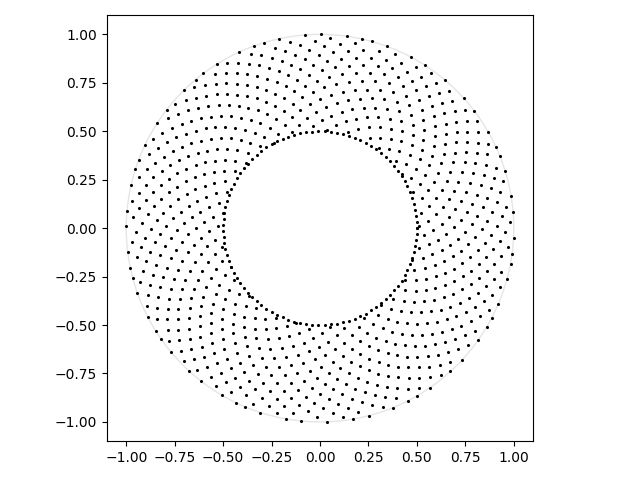

933
933
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
    VERB2::populate_spangler:: Sample size 200 is different from spangles

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,24507,0,2,1,"[0, 0, 0]",0.125699,-0.486857,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,1.0,1.0,"[0.0, 0.0, 0.0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,1.0,1.0,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,24507,0,2,1,"[0, 0, 0]",0.239680,0.450479,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,1.0,1.0,"[0.0, 0.0, 0.0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,1.0,1.0,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,24507,0,2,1,"[0, 0, 0]",-0.487948,-0.172717,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,1.0,1.0,"[0.0, 0.0, 0.0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,1.0,1.0,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
3,24507,0,2,1,"[0, 0, 0]",0.483131,-0.205076,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,1.0,1.0,"[0.0, 0.0, 0.0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,1.0,1.0,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
4,24507,0,2,1,"[0, 0, 0]",-0.220681,0.484065,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,1.0,1.0,"[0.0, 0.0, 0.0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,1.0,1.0,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
  VERB1::update_state:: Updating state: visibility and illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,24507,0,2,1,"[0, 0, 0]",0.125699,-0.486857,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",-0.433143,0.147442,-0.208515,0.457550,2.813495,-0.414689,0.57735,1.940566,"[0.0, 0.0, 0.0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,1.0,1.0,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,24507,0,2,1,"[0, 0, 0]",0.239680,0.450479,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.149057,-0.281756,0.398463,0.318755,5.198989,0.780884,0.57735,1.333588,"[0.0, 0.0, 0.0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,1.0,1.0,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,24507,0,2,1,"[0, 0, 0]",-0.487948,-0.172717,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.222902,0.269716,-0.381435,0.349902,0.880145,-0.736910,0.57735,2.113486,"[0.0, 0.0, 0.0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,1.0,1.0,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
3,24507,0,2,1,"[0, 0, 0]",0.483131,-0.205076,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",-0.486636,-0.113515,0.160535,0.499700,3.370760,0.305866,0.57735,1.571516,"[0.0, 0.0, 0.0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,1.0,1.0,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
4,24507,0,2,1,"[0, 0, 0]",-0.220681,0.484065,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.498330,-0.107526,0.152065,0.509799,6.070671,0.285839,0.57735,1.579986,"[0.0, 0.0, 0.0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,1.0,1.0,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,0.023562,0.173205,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-0.70710678  0.          0.70710678] [0.70710678 0.         0.70710678]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::populate_spangler:: Purging 3d sample
  VERB1::purge_sample::

.

    VERB2::populate_spangler:: Sample size 987 is different from spangles 1000. Adjusting.
    VERB2::populate_spangler:: Removing 13 entries to DataFrame
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
987 987 987



----------------------------------------------------------------------
Ran 1 test in 2.375s

OK


In [147]:
if IN_JUPYTER:
    def test_pop(self):
        Verbose.VERBOSITY=VERB_ALL
        
        #Using preset
        sg=Spangler(nspangles=850)
        sg.populate_spangler(geometry="ring",preset=True,ri=0.5)
        sg.sample.plot()
        print(sg.sample.N)
        print(sg.nspangles)
    
        #Ring
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="ring",scale=1,seed=1,boundary=0)
        print_df(sg.data.head(5))
        sg.set_observer(nvec=[1,1,1])
        print_df(sg.data.head(5))
        
        #Sphere
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        print(sg.nspangles,sg.sample.N,len(sg.data))
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [148]:
def plot3d(self,
           center_at=None,
           not_plot=[],
           factor=1.2,
           show_hidden=True,
           figsize=(5,5)
          ):
    """Plot spangle in 3d.

    Optional parameters:
    
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see body_hash column
            of the Spangler DataFrame).
            
        not_plot: list of strings, default = []:
            List of object hashes to not plot.

        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
        factor: float, default = 1.2:
            Size of the 
    """
    bgcolor='k'

    #Center
    cond=(self.data.body_hash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][["x_ecl","y_ecl","z_ecl"]].mean() if sum(cond)>0 else np.array([0,0,0])
    
    #Figure
    fig=plt.figure(figsize=figsize)
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)
    ax.axis("off")
    
    #Spangles
    for i in range(self.nspangles):

        #Avoid plotting 
        bhash=self.data.loc[i,"body_hash"]
        if bhash in not_plot:
            continue
        
        #Reference transparency of spangles
        alpha_base=0.5

        #Avoid hidden spangles
        if self.data.loc[i,"hidden"]:
            continue

        spangle_type=self.data.loc[i,"type"]

        #Define color according to illumination
        if self.data.loc[i,"illuminated"]:
            color=Misc.rgb(SPANGLE_COLORS[spangle_type]) #Planet color
        else:
            color=Misc.rgb(SHADOW_COLOR) #Gray

        if self.data.loc[i,"transmit"]:
            alpha_base=0.2

        #Define alpha according to albedo
        alpha=alpha_base*self.data.albedo_gray_normal[i]

        center=[self.data.x_ecl[i]-x_cen,self.data.y_ecl[i]-y_cen,self.data.z_ecl[i]-z_cen]
        radius=self.data.dsp[i]/2
        zDir=self.data.ns_ecl[i]

        #Change properties according to visibility
        ec=color
        lw=0
        if ~self.data.loc[i,"visible"]:
            ec='k'
            lw=0
            alpha*=0.5

        #verbose(VERB_DEEP,i,center,radius,zDir)
        Plot.circle3d(ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color=color,alpha=alpha,ec=ec,lw=lw)

    #Aspect
    ax.set_box_aspect([1,1,1])

    #Zoom around center
    cond=(self.data.body_hash==center_at)
    cond=cond if sum(cond)>0 else [True]*self.nspangles

    #Not 
    cond=cond&(~self.data.body_hash.isin(not_plot))
    
    #Range
    maxval=1.0*np.abs(self.data[cond][["x_ecl","y_ecl","z_ecl"]].to_numpy()-[x_cen,y_cen,z_cen]).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,r"$x_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,r"$y_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,r"$z_{ecl}$",color='w',alpha=0.5,fontsize=8)
    
    #Light
    increase=1.05*factor*maxval
    ax.quiver(+self.n_luz[0]*increase,+self.n_luz[1]*increase,+self.n_luz[2]*increase,
              -self.n_luz[0]*increase,-self.n_luz[1]*increase,-self.n_luz[2]*increase,
              color='y',alpha=0.7)
    ax.text(self.n_luz[0]*increase,self.n_luz[1]*increase,self.n_luz[2]*increase,
            r"$n_{luz}$",color='w',alpha=0.7,fontsize=8,ha='left',va='bottom')
    
    #Observer
    ax.quiver(+self.n_obs[0]*increase,+self.n_obs[1]*increase,+self.n_obs[2]*increase,
              -self.n_obs[0]*increase,-self.n_obs[1]*increase,-self.n_obs[2]*increase,
              color='c',alpha=0.7)
    ax.text(self.n_obs[0]*increase,self.n_obs[1]*increase,self.n_obs[2]*increase,
            r"$n_{obs}$",color='c',alpha=0.7,fontsize=8,ha='right',va='top')
    
    #Title
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)
    
    #Scale
    ax.text2D(0,0,f"Axis scale: {maxval*factor:.2g}",
            fontsize=8,color='w',
            transform=ax.transAxes)

    #Orientation
    r_obs,t_obs,f_obs=sci.spherical(self.n_obs)
    ax.view_init(f_obs*Consts.rad,t_obs*Consts.rad)
    fig.tight_layout()

    self.fig3d=fig
    self.ax3d=ax

Spangler.plot3d=plot3d

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::populate_spangler:: Purging 3d sam

<IPython.core.display.Javascript object>


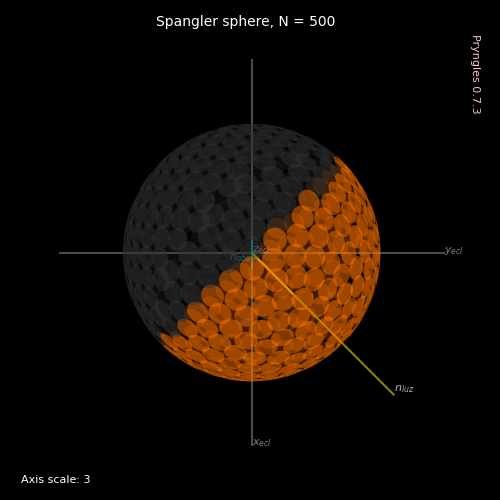

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
    VERB2::populate_spangler:: Sample size 

<IPython.core.display.Javascript object>


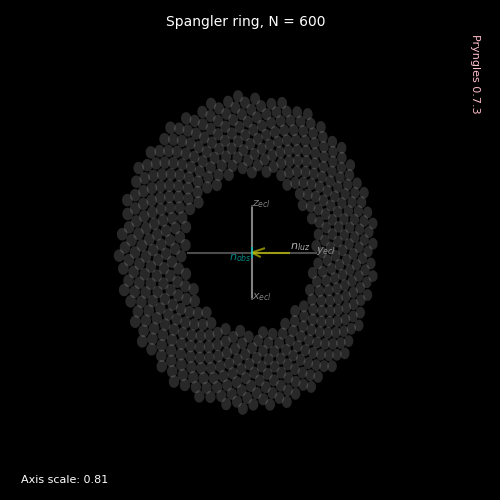

.
----------------------------------------------------------------------
Ran 1 test in 1.668s

OK


In [149]:
if IN_JUPYTER:
    def test_plot3d(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        plt.close("all")
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.set_luz(nvec=[1,1,0])
        sg.plot3d(factor=1.5)
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2,seed=1,boundary=0)
        sg.set_luz(nvec=[-1,1,-1])
        sg.set_observer(nvec=[1,0,1])
        sg.plot3d(show_hidden=True,factor=0.5,center_at="1234")

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [150]:
def plot_obs(self,show_hidden=True,center_at=None,not_plot=[],**args):
    """
    Plot spangle.

    Optional parameters:
    
        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see body_hash column
            of the Spangler DataFrame).
            
        args: dictionary, default = dict(c='c',s=0.1):
            Scatter plotting options, dictionary.
    """
    sargs=dict(c='c',sizes=3.5)
    sargs.update(args)
    bgcolor='k'

    #Center of plot
    cond=(self.data.body_hash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][["x_obs","y_obs","z_obs"]].mean() if sum(cond)>0 else np.array([0,0,0])

    #Maxval original
    maxval_full=1.2*np.abs(self.data[["x_obs","y_obs","z_obs"]].to_numpy()-[x_cen,y_cen,z_cen]).max()

    #Select plotting bodies
    yes_plot=(~self.data.body_hash.isin(not_plot))
    nyes_plot=sum(yes_plot)
    if nyes_plot==0:
        raise AssertionError(f"No body remain after removing {not_plot}")
    data=self.data[yes_plot]
    
    #Select scale for plot
    cond=cond if sum(cond)>0 else [True]*nyes_plot        
    maxval=1.2*np.abs(data[cond][["x_obs","y_obs","z_obs"]].to_numpy()-[x_cen,y_cen,z_cen]).max()
    size_factor=maxval_full/maxval
        
    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot according to state
    colors=np.array(['#000000']*nyes_plot) #Black
    sizes=np.array([0.0]*nyes_plot)

    #No illuminated
    cond=(data.visible)&(~data.illuminated)
    colors[cond]=Misc.rgb(SHADOW_COLOR,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Illuminated
    cond=(data.visible)&(data.illuminated)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                           to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Transmit
    cond=(data.visible)&(data.transmit)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                           to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=0.5*size_factor*data.scale[cond]
    
    #Plots
    sargs.update(dict(c=colors,sizes=sizes))    
    ax.scatter(data.x_obs-x_cen,data.y_obs-y_cen,**sargs)
    
    #Show hidden spangles
    if show_hidden:
        cond=(self.data.hidden)
        sargs.update(dict(c='r',sizes=1.5*data.scale[cond],ec='r',fc='r'))    
        ax.scatter(data.x_obs[cond]-x_cen,data.y_obs[cond]-y_cen,**sargs)

    #Ranges
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,r"$x_{obs}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,r"$y_{obs}$",color='w',alpha=0.5,fontsize=8)

    #Title
    lamb_obs=self.rqf_obs[1]*Consts.rad
    phi_obs=self.rqf_obs[2]*Consts.rad
    label_obs=f"Obs ($\lambda$,$\\beta$) : ({lamb_obs:.1f}$^\circ$,{phi_obs:.1f}$^\circ$)"
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}, {label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
    Plot.pryngles_mark(ax)

    #Scale
    center_text=""
    if center_at:
        center_text=f", Center at '{center_at}'"
    ax.text(0,0,f"Axis scale: {maxval*factor:.2g}{center_text}",
              fontsize=8,color='w',
              transform=ax.transAxes)

    #Decoration
    fig.tight_layout()
    self.fig2d=fig
    self.ax2d=ax

Spangler.plot_obs=plot_obs

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 2]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::populate_spangler:: Populating spa

<IPython.core.display.Javascript object>


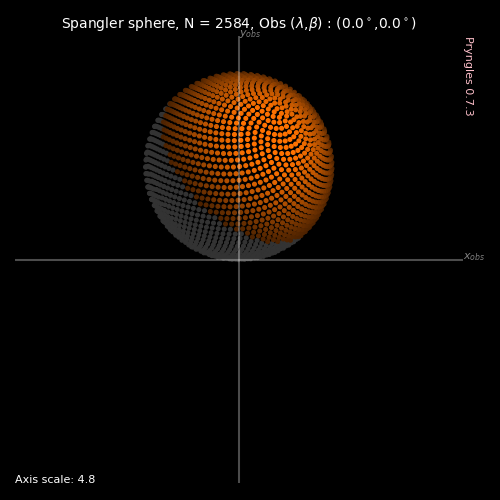

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [1, 1, 1]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::populate_spangler:: Populating spa

<IPython.core.display.Javascript object>


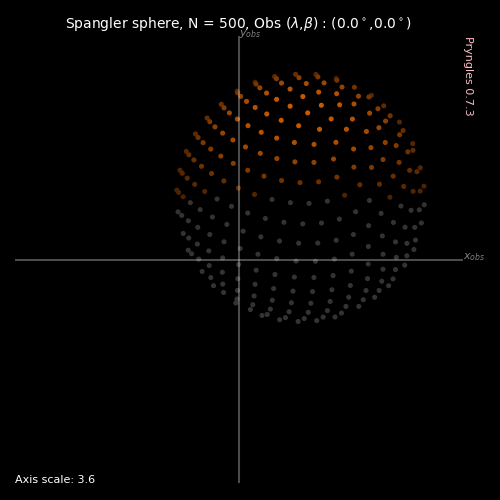

  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination


<IPython.core.display.Javascript object>


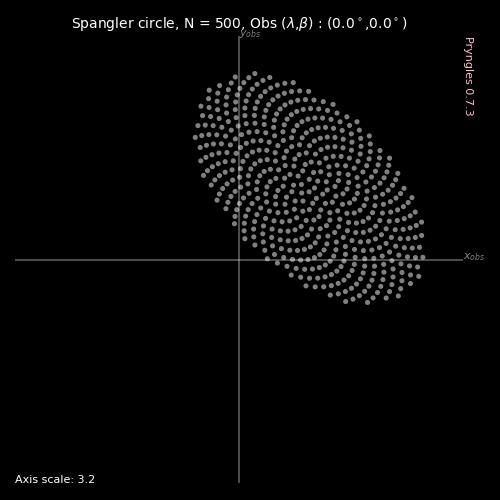

  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0, 0, -1]
      VERB3::rotation_matrix:: Rotation axis: [-1  0  0] [0. 1. 0.] [ 0.  0. -1.]
  VERB1::update_state:: Updating state: visibility and illumination
    VERB2::populate_spangler:: Sample size 599 is different from spangles 500. Adjusting.
    VERB2::populate_spangler:: Adding 99 entries to DataFrame
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [ 0.  0. -1.]
      VERB3::rotation_matrix:: Rotation axis: [-1  0  0] [0. 1. 0.] [ 0.  0. -1.]
  VERB1::update_state:: Updating state: visibility and illuminat

<IPython.core.display.Javascript object>


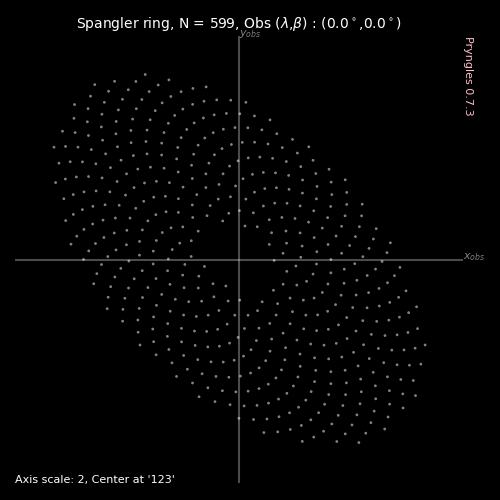

.
----------------------------------------------------------------------
Ran 1 test in 1.832s

OK


In [152]:
if IN_JUPYTER:
    def test_plotobs(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sg=Spangler(nspangles=2500,body_hash="123",n_equ=[1,1,1],center_ecl=[0,0,2])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.set_luz(nvec=[1,1,1])
        sg.plot_obs()
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1],center_ecl=[1,1,1])

        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.plot_obs()

        sg.populate_spangler(geometry="circle",spangle_type=GRANULAR_SPANGLE,scale=2,seed=1,boundary=0)
        sg.plot_obs()

        sg.set_luz(nvec=[0,0,-1])
        sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2,seed=1,ri=0.2,boundary=0)
        sg.plot_obs(center_at="123",show_hidden=0)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [153]:
def _join_spanglers(self,spanglers,n_obs=[0,0,1],alpha_obs=0,n_luz=[0,0,1]):
    """
    Join spanglers into a single spangler
    
    Parameters:
        spanglers: list of Spanglers:
            Spanglers to join.
            
        n_obs: array(3), default = [0,0,1]:
            Direction of observer.
            
        n_luz: array(3), default = [0,0,1]:
            Direction of light-source.
            
    Return:
        
    """
    #Set of spanglers
    self.spanglers=spanglers
    
    #Concatenate data
    datas=[spangler.data for spangler in spanglers]
    self.data=pd.concat(datas,ignore_index=True)
    
    #Create a list of hashehs
    self.body_hash=[spangler.body_hash for spangler in spanglers]
    
    #Join properties
    self.nspangles=len(self.data)
    self.geometry="Join"
    
    #Set luz and set observer
    self.set_observer(n_obs,alpha_obs)
    self.set_luz(n_luz)
    
Spangler._join_spanglers=_join_spanglers

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 5]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-0.98058068  0.          0.19611614] [0.19611614 0.         0.98058068]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from nvec = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_state:: Updating state: visibility and illumination
    VERB2::populate_spangler:: Sample size 1100 is different from span

<IPython.core.display.Javascript object>


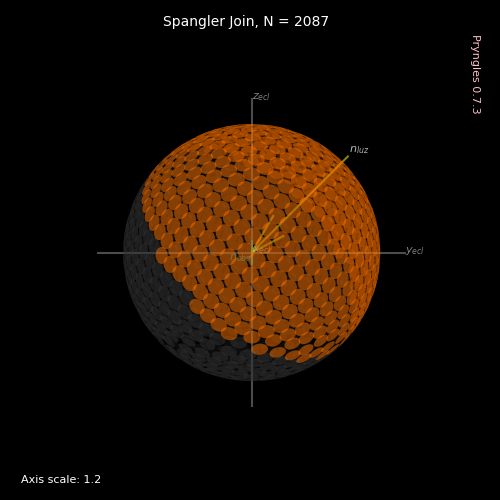

<IPython.core.display.Javascript object>


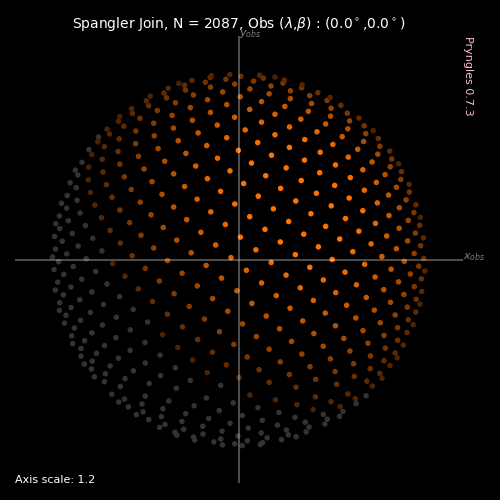

<IPython.core.display.Javascript object>


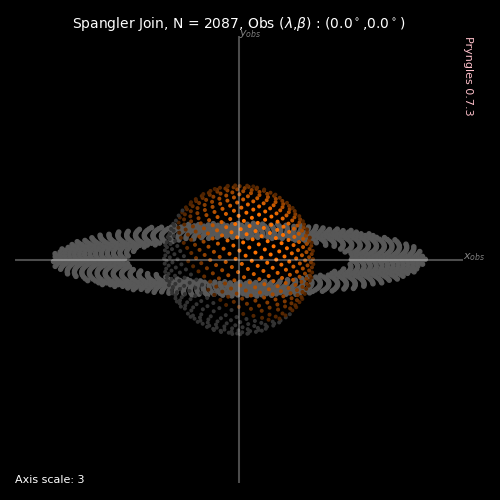

.
----------------------------------------------------------------------
Ran 1 test in 1.834s

OK


In [154]:
if IN_JUPYTER:
    def test_join(self):
        
        Verbose.VERBOSITY=VERB_ALL

        sg1=Spangler(nspangles=1000,body_hash="Ring",n_equ=[1,0,5])
        sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

        sg2=Spangler(nspangles=1000,body_hash="Planet",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

        sgj=Spangler(spanglers=[sg1,sg2],n_obs=[1,0,0],n_luz=[+1]*3)

        sgj.plot3d(not_plot=["Ring"])
        sgj.plot_obs(show_hidden=0,not_plot=["Ring"])
        sgj.plot_obs(show_hidden=0,not_plot=[])
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_join=test_join
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [181]:
# Set scale
def set_scale(self,scale):
    lengths=[
        "x_equ","y_equ","z_equ",
        "x_ecl","y_ecl","z_ecl",
        "x_obs","y_obs","z_obs","d_obs",
        "x_luz","y_luz","z_luz","d_luz",
        "r_equ","rho_obs","rho_luz",
        "dsp",
    ]
    self.scale=scale
    self.data[lengths]*=self.scale
    areas=[
        "asp",
    ]
    self.data[areas]*=self.scale**2
    vectors=[
        "center_ecl",
        "center_equ",
        "center_obs",
    ]
    for vector in vectors:
        self.data[vector]=[np.array(v)*scale for v in self.data[vector]]
    
Spangler.set_scale=set_scale

In [183]:
if IN_JUPYTER:
    def test_scale(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(center_ecl=[1,1,1],center_equ=[1,1,1])
        print_df(sg.data)

        sg.set_scale(5)
        print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_scale=test_scale
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
  VERB1::update_state:: Updating state: visibility and illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,10697,0,2,1,"[1, 1, 1]",3.0,2.0,3.0,"[0.0, 0.0, 1.0]","[1.0, 1.0, 1.0]",3.0,2.0,3.0,2.236068,0.463648,0.666667,1.0,-2.0,"[1.0, 1.0, 1.0]",3.0,2.0,3.0,2.236068,0.463648,0.666667,1.0,-2.0,"[1, 1, 1]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,10697,0,2,1,"[5, 5, 5]",15.0,10.0,15.0,"[0.0, 0.0, 1.0]","[5.0, 5.0, 5.0]",15.0,10.0,15.0,11.18034,0.463648,0.666667,1.0,-10.0,"[1.0, 1.0, 1.0]",15.0,10.0,15.0,11.18034,0.463648,0.666667,1.0,-10.0,"[5, 5, 5]",5,0,5,5,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,25.0,5.0,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.101s

OK


In [184]:
def reset_state(self):
    self.data[list(SPANGLER_SOURCE_STATES)+list(SPANGLER_VISIBILITY_STATES)]=False
    self.data["unset"]=True
    
Spangler.reset_state=reset_state

In [185]:
if IN_JUPYTER:
    def test_reset(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(nspangles=100)
        sg.reset_state()
        print_df(sg.data.head())

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_reset=test_reset
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
  VERB1::update_state:: Updating state: visibility and illumination
  VERB1::set_luz:: Setting light-source
  VERB1::update_state:: Updating state: visibility and illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cos_tobs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cos_tluz,cos_luz,d_luz,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,n_equ,alpha_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,39502,0,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
1,39502,0,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
2,39502,0,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
3,39502,0,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
4,39502,0,2,1,"[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0.0, 0.0, 0.0]",1.0,0.0,1.0,1.0,6.283185,0.707107,1.0,0.0,"[0, 0, 0]",1,0,1,1,0,0,"[0, 0, 1]","[0.0, 0.0, 1.0]",0,0,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.217s

OK


--End--